$\hspace*{12cm} Baptiste \; Jarys \qquad Léo \; Ouvrier-Bonnaz $  
$\hspace*{17cm} Groupe \; 8A $
$\\$

# <span style='color:red'> TP Calcul Scientifique Numérique : Tube à Choc </span>

$\\$

##### Résumé du problème :

$\qquad$ Nous cherchons à modéliser le dispositif expérimental du tube à choc qui permet de générer une onde de choc. Ce dispositif est composé de deux chambres séparées par un diaphragme : une à haute et une à basse pressions. Dans chacune d'elles, un gaz est mis sous pression, avec une différence de pression entre les deux chambres. A l’instant initial, le diaphragme est rompu, et une onde de choc se propage. Elle se propage dans la chambre basse pression tandis qu’une onde de détente se propage dans la chambre haute pression. Nous considérons la nature du gaz comme étant l’air.  
Nous traitons uniquement dans ce problème des versions simplifiées de l'équation de quantité de mouvement :  
$$ \frac{\partial u }{\partial t} + u\frac{\partial u}{\partial x} + \frac{1}{\rho }\frac{\partial p}{\partial x} = 0 $$

In [53]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import pandas as pd
import os

$ $ 

## <span style='color:red'> 1. Equation de convection linéaire : </span>

$\\$ 

On se propose dans un premier temps d'étudier l'équation de convection linéaire, dont l'expression est la suivante :  
##### $$ \frac{\partial u}{\partial t} + c \; \frac{\partial u}{\partial x} = 0 \qquad \textrm{avec } \; \mathbf{c} \; \textrm{ une quantité scalaire représentant une vitesse} $$

Nous considérons les conditions initiales du problème de Riemann, c’est-à-dire :
$$ u(0,x) = \left\{\begin{matrix}
u_{l}~si~x<x_{D} \\ 
u_{r}~si~x>x_{D}
\end{matrix}\right. $$

Il s'agit d'une équation aux dérivées partielles linéraire, homogène et d'ordre 1.

##### <span style='color:blue'> Discrétisation de l'équation : </span>

$\qquad$ Pour discrétiser l'équation, on choisit un schéma d'ordre 1 avant en temps, et un schéma d'ordre 1 arrière en espace (direction opposée à celle de la propagation). Les dérivées spatiales et temporelles s'expriment donc comme suit :
$$ \left ( \frac{\partial u}{\partial t} \right )_{i}^{n} = \frac{u_{i}^{n+1} - u_{i}^{n}}{\Delta t} $$
$$ \left ( \frac{\partial u}{\partial x} \right )_{i}^{n} = \frac{u_{i}^{n} - u_{i-1}^{n}}{\Delta x} $$

On obtient ainsi en isolant le terme $u_{i}^{n+1}$ :
$$ u_{i}^{n+1} = (1 - CFL) \; u_{i}^{n} + CFL \; u_{i-1}^{n} \qquad \textrm{avec} \quad CFL = c \; \frac{\Delta t}{\Delta x} \qquad (\ast ) $$

On choisit dans cette partie une résolution matricielle du problème, qui s'écrit alors :

$$
\mathbf{
\begin{pmatrix}u_{1}
\\ \vdots
\\ \vdots
\\ \vdots
\\ u_{N}
\end{pmatrix}^{n+1}
= \quad
\begin{pmatrix}
1-CFL & 0 & ... & ... & 0\\ 
CFL & 1-CFL & 0 & ... & 0\\ 
0 & \ddots & \ddots & \ddots & \vdots \\ 
\vdots  & \ddots  & CFL & 1-CFL & 0\\ 
0 & ... & 0 & CFL & 1-CFL
\end{pmatrix}
\;
\begin{pmatrix}u_{1}
\\ \vdots
\\ \vdots
\\ \vdots
\\ u_{N}
\end{pmatrix}^{n}
}
$$
En ajoutant des conditions aux limites, on a alors existence et unicité de la solution au problème. On choisira que la vitesse au point le plus à gauche sera constamment égale à $u_{L}$, et celle le plus à droite à $u_{R}$, c'est-à-dire $u(t, 0) = u_{L} \; et \; u(t, 1) = u_{R}$.  
Cela pourrait se démontrer en utilisant le théorème de Lax-Milgram. Pour cela, on exprime l'équation en formulation faible sous la forme $a(u,v) = l(v)$.
Il y a alors existence et unicité de la solution si :  
- a est biliniéaire
- a est continue : $\exists \, M \geq 0, |a(u,v)| \leq M \, ||u||_{H^{1}} \, ||v||_{H^{1}}$
- a est coercive : $\exists \, \alpha \gt 0, \, a(v,v) \geq \alpha \, ||v||_{H^{1}}^{2}$
- l est une forme linéaire
- l est continue : même démonstration

##### <span style='color:blue'> Stabilité du système :  </span> 
On pose $$ u_{j}^{n} = A \; g^{n}(k) \; e^{ik(j-1)\Delta x}$$
et après réinjection dans $(\ast )$ et simplifications, on trouve :$$ g = (1 - CFL + CFL cos\phi )-i(CFL \; sin\phi )  \qquad \textrm{avec} \quad \phi = k \Delta x $$
Le critère de Von Neumann $\textrm{|g| < 1}$ donne la condition de stabilité suivante : $$ \mathbf{0 < CFL<1} $$

##### <span style='color:blue'> Programmation de la résolution :  </span>

##### Définition des paramètres :

In [54]:
# Taille de la matrice :
N = 300
# Nombre d'itérations :
It = 500

# Vitesse initiale à droite du diaphragme :
ur = 1
# Vitesse initiale à gauche du diaphragme :
ul = 2
# Position du diaphragme (entier entre les positions 0 et N) :
xD = int(N/2)

# Valeur du CFl entre 0 et 1 pour la stabilité :
CFL = 0.5

##### Vecteur des vitesses initiales $U_{0}$ :

In [55]:
U0 = np.zeros((N,1))
U0[:xD] = ul        # Vitesse à gauche du diaphragme
U0[xD:] = ur        # Vitesse à droite du diaphragme
# print(U0)

##### Définition matrice de dimensions N x N :

In [56]:
Matrice = np.zeros((N,N))
for i in range (0,N-1):
        Matrice[i,i]=1-CFL              # Diagonale principale
        Matrice[i+1,i] = CFL            # Diagonale inférieure
Matrice[N-1,N-1] = 1 - CFL
print(Matrice)        

[[0.5 0.  0.  ... 0.  0.  0. ]
 [0.5 0.5 0.  ... 0.  0.  0. ]
 [0.  0.5 0.5 ... 0.  0.  0. ]
 ...
 [0.  0.  0.  ... 0.5 0.  0. ]
 [0.  0.  0.  ... 0.5 0.5 0. ]
 [0.  0.  0.  ... 0.  0.5 0.5]]


##### Résolution de l'équation :

On introduit ici une liste $U_{t}$ contenant l'intégralité des profils de vitesses, pour tous les temps. 
A $U_{t}[i]$ est donc attribué le profil de vitesses au temps i.

In [57]:
U=U0                        # Initialisation du vecteur vitesse pour t=0
Ut=[U]                      # On introduit le profil initial de vitesses dans la liste

for i in range(0,It):       # Résolution par produits matriciels successifs
    U=np.dot(Matrice,U)
    U[0]=ul                 # Conditions aux limites
    U[N-1]=ur
    Ut.append(U)
# print(U)

##### Affichage des résultats :

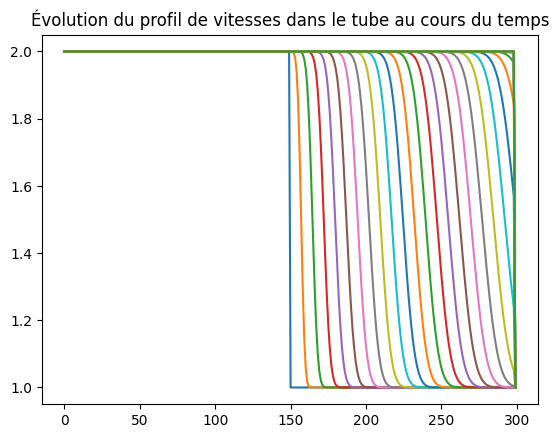

In [58]:
absc = list(range(0,N))         # Abscisse du graphe

for i in range (0, It//15) :        # Affichage de certains profils
    plt.plot(absc,Ut[i*15])
        
# plt.plot(absc,Ut[It-1])       # Affichage d'un profil pour un temps particulier

plt.title('Évolution du profil de vitesses dans le tube au cours du temps')
plt.show()

##### <span style='color:blue'> Commentaires : </span>

$\qquad$ On observe bien une propagation de la vitesse/du choc, initialement à $x_{D}$, au sein du dispositif. En effet, le profil de vitesses initialement à gauche se déplace au cours du temps. De plus, la vitesse finale observée dans le piston est cohérente avec les paramètres d'entrée et le phénomène physique. En effet, elle tend bien vers la vitesse imposée dans la chambre de gauche, ul, puisque la propagation se fait de la gauche vers la droite.  
La position du diaphragme n'a aucune influence sur le phénomène observé. Il en est de même avec la valeur des vitesses initiales et leur ordre de supériorité ($u_{l} > u_{r}$ ou $u_{l} < u_{r}$)  
La valeur du CFL joue sur la vitesse de la propagation. On observe que plus le CFL est grand, moins le nombre d'itérations à réaliser est important pour que le profil de vitesses se retrouve le plus à droite.   
Dernier constat cohérent : si les vitesses initiales sont identiques à droite et à gauche du diaphragme, aucune propagation n'a lieu.

$ $  
$ $
$ $

## <span style='color:red'> 2. Equation de convection-diffusion </span>

$\qquad$ Dans un second temps, on s'intéresse à l'équation de convection-diffusion, équation de convection linéiare à laquelle est ajouté un terme liée à la viscosité.  
Son expression est la suivante :
##### $$ \frac{\partial u}{\partial t} + c \; \frac{\partial u}{\partial x} = \nu \; \frac{\partial ^{2}u}{\partial x^{2}} \qquad \qquad \textrm{avec } \; \mathbf{c} \; \textrm{ une quantité scalaire représentant une vitesse et }  \; \mathbf{\nu} \; \textrm{ la viscosité cinématique}$$  
$ $  
Nous considérons les mêmes conditions initiales qu'au problème précédent.  

Il sagit d'une équation aux dérivées partielles linéaire, parabolique, homogène, et d'ordre 2.

##### <span style='color:blue'> Discrétisation de l'équation : </span>

Pour discrétiser l'équation, on choisit un schéma d'ordre 1 avant en temps, et un schéma centré d'ordre 2 pour les autres termes :
$$ \left ( \frac{\partial u}{\partial t} \right )_{i}^{n} = \frac{u_{i}^{n+1} - u_{i}^{n}}{\Delta t} $$
$$ \left ( \frac{\partial u}{\partial x} \right )_{i}^{n} = \frac{u_{i+1}^{n} - u_{i-1}^{n}}{2\Delta x} $$
$$ \left ( \frac{\partial^{2} u}{\partial x^{2}} \right )_{i}^{n} = \frac{u_{i+1}^{n} - 2u_{i}^{n}+u_{i-1}^{n}}{\Delta x^{2}} $$
$ $  
$\qquad$ Une discrétisation par un schéma centré d'ordre 2, pour la dérivée première en espace, impose l'utilisation d'une viscosité numérique . En effet, en l'absence de cette dernière, ce choix de modélisation implique une divergence de la solution. Le terme de l'équation $\nu \frac{\partial^{2} u}{\partial x^{2}}$ permet ainsi d'atténuer les oscillations et de rendre le problème stable.  
$ $  
En revenant sur l'équation de convection-diffusion, on obtient en isolant le terme $u_{i}^{n+1}$ :
$$ u_{i}^{n+1} = (S-\frac{CFL}{2})u_{i+1}^{n} + (1-2S)u_{i}^{n} + (S+\frac{CFL}{2})u_{i-1}^{n} \qquad \textrm{avec} \quad S = \frac{\nu  \Delta t}{\Delta x^{2}},\quad CFL = c \; \frac{\Delta t}{\Delta x}$$  
On choisit également une résolution matricielle de ce problème, qui s'écrit alors :  
$$
\begin{pmatrix}u_{1}
\\ \vdots
\\ \vdots
\\ \vdots
\\ u_{N}
\end{pmatrix}^{n+1}
= \quad
\begin{pmatrix}
1-2S & S-\frac{CFL}{2} & 0 & ... & 0\\ 
S+\frac{CFL}{2} & 1-2S & S-\frac{CFL}{2} & \ddots & \vdots \\ 
0 & \ddots & \ddots & \ddots & 0 \\ 
\vdots  & \ddots  & S+\frac{CFL}{2}& 1-2S & S-\frac{CFL}{2}\\ 
0 & ... & 0 & S+\frac{CFL}{2}& 1-2S
\end{pmatrix}
\;
\begin{pmatrix}u_{1}
\\ \vdots
\\ \vdots
\\ \vdots
\\ u_{N}
\end{pmatrix}^{n} \;
+ \quad
\begin{pmatrix}u_{L}*(S+\frac{CFL}{2})
\\ 0
\\ \vdots
\\ 0
\\ u_{R}*(S-\frac{CFL}{2})
\end{pmatrix}
$$

De même ici, en ajoutant des conditions aux limites, on a alors existence et unicité de la solution au problème (peut se démontrer avec Lax-Milgram comme expliqué dans la partie 1). Le vecteur représenté le plus à droite ci-dessus correspond à ces conditions.

##### <span style='color:blue'> Stabilité du système :  </span> 
Le changement de fonction inconnue donne après simplification :
$$ g = [(1 - 2S(1 -cos \ \phi )]-i \; CFL \; sin \ \phi  \qquad \text{avec} \quad \phi = k \Delta x $$
Le critère de Von Neumann |g| < 1 donne les conditions de stabilité suivantes : $$ \mathbf{S\geq \frac{CFL^{2}}{2}} \qquad \textrm{et} \qquad \mathbf{CFL^{2}\leq 1} $$

##### <span style='color:blue'> Programmation de l'équation :  </span>

Le principe de résolution de ce problème est identique à celle réalisée précédement.

##### Définition des paramètres :

In [83]:
# Taille de la matrice :
N = 300
# Nombre d'itérations :
It = 250

# Vitesse initiale à droite du diaphragme :
ur = 1
# Vitesse initiale à gauche du diaphragme :
ul = 2
# Position du diaphragme :
xD = int(N/2)

# Conditions de stabilité :
CFL = 0.6       # CFL² <= 1                  
S = 0.2        # S => CFL²/2
print(("CFL² = "), CFL**2, ('; CFL²/2 = '), CFL**2/2, ("; S = "), S)

CFL² =  0.36 ; CFL²/2 =  0.18 ; S =  0.2


##### Vecteur vitesse initial $U_{0}$ :

In [84]:
U0 = np.zeros((N,1))
U0[:xD] = ul        # Vitesse à gauche du diaphragme
U0[xD:] = ur        # Vitesse à droite du diaphragme
# print(U0)

##### Définition de la matrice :

In [85]:
Matrice = np.zeros((N,N))
for i in range (0,N-1):
        Matrice[i,i]=1-2*S                              # Diagonale principale
        Matrice[i+1,i] = S+CFL/2                        # Diagonale inférieure
        Matrice[i,i+1] = S-CFL/2                        # Diagonale supérieure
Matrice[N-1,N-1] = 1 -2*S
print(Matrice)

[[ 0.6 -0.1  0.  ...  0.   0.   0. ]
 [ 0.5  0.6 -0.1 ...  0.   0.   0. ]
 [ 0.   0.5  0.6 ...  0.   0.   0. ]
 ...
 [ 0.   0.   0.  ...  0.6 -0.1  0. ]
 [ 0.   0.   0.  ...  0.5  0.6 -0.1]
 [ 0.   0.   0.  ...  0.   0.5  0.6]]


##### Vecteur des conditions aux limites :

In [86]:
Ulimit = np.zeros((N,1))
Ulimit[0] = (S + CFL/2) * ul
Ulimit[N-1] = (S - CFL/2) * ur
# print(Ulimit)

##### Résolution de l'équation :

In [87]:
U=U0                                # Initialisation du vecteur vitesse pour t=0
Ut=[U]                              # On introduit le profil initial de vitesses dans la liste

for i in range(0,It):               # Résolution par produits matriciels successifs
    U=np.dot(Matrice,U) + Ulimit
    Ut.append(U)
#print(U)

##### Affichage des résultats :

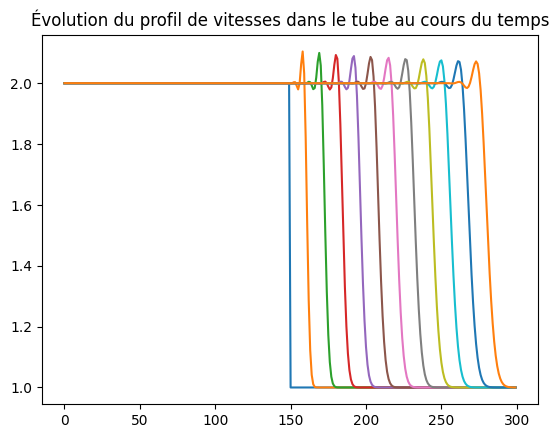

In [88]:
absc = list(range(0,N))         # Abscisse du graphe

for i in range (0, It//20) :        # Affichage de tous les profils
    plt.plot(absc,Ut[i*20])

# plt.plot(absc,Ut[150])        # Affichage d'un profil pour un temps particulier

plt.title('Évolution du profil de vitesses dans le tube au cours du temps')
plt.show()

##### <span style='color:blue'> Observations : </span>

Globalement, les constats réalisés pour la modélisation de convection linéiare restent valables ici. On remarque que pour une valeur S > 0.5, les vitesses divergent, et ce, peut importe la valeur du CFL. Ce problème peut être relié à une valeur limite du coefficient de viscosité $\nu_{limite}$ au delà duquel le système n'est plus stable.  
Par ailleurs, si la valeur de S est proche de $\frac{CFL^{2}}{2}$, on observe de légers dépassement sur les profils de vitesses, liés à l'erreur dispersive, propre à ce type de modélisation. Ils semblent être absents sinon. 

 $ $

## <span style='color:red'> 3. Equations de Burgers </span>

Finalement, on décide de limiter l'équation de quantité de mouvement à l'équation de Burgers, dont l'équation est donnée ci-dessous :
##### $$ \frac{\partial u}{\partial t} + u \; \frac{\partial u}{\partial x} = 0$$

#### <span style='color:red'> 3.1 Résolution avec les conditions initiales de l'énoncé : </span>

Nous considérons de nouvelles conditions initiales pour ce problème :
$$
u(0,x) = 
\left\{\begin{matrix}
u_{l} \quad si \quad x<x_{D} - \frac{l}{2}
\\ -\frac{u_{l}-u_{r}}{l} x + (u_{l}+\frac{u_{l}-u_{r}}{l}(x_{D}-\frac{l}{2}{})) \quad si \quad x_{D} - 
\frac{l}{2} \leq x \leq x_{D} + \frac{l}{2}
\\ u_{r} \quad si \quad x>x_{D} + \frac{l}{2}
\end{matrix}\right.
$$

Il s'agit d'une équation aux dérivées partielles non linéaire, homogène et d'ordre 1.

##### <span style='color:blue'> Discrétisation de l'équation : </span>

On peut montrer que la solution obtenue en discrétisant l'équation présentée ci-dessus ne converge pas vers la solution exacte. Il faut imposer une condition supplémentaire numérique : l'équation doit être écrite sous la forme conservative suivante :
##### $$ \frac{\partial u}{\partial t} + \frac{\partial F(u)}{\partial x} = 0, \qquad x \in [0,1] \qquad \textrm{où F désigne le flux de la variable u} \; : \: F(u) = \frac{u^{2}}{2}$$

Pour discrétiser l'équation, on choisit un schéma d'ordre 1 avant en temps, et un schéma décentré arrière d'ordre 1 pour le flux (schéma rétrograde) :
$$ \left ( \frac{\partial u}{\partial t} \right )_{i}^{n} = \frac{u_{i}^{n+1} - u_{i}^{n}}{\Delta t} $$
$$ \left ( \frac{\partial F}{\partial x} \right )_{i}^{n} = \frac{F_{i}^{n} - F_{i-1}^{n}}{\Delta x} $$

On obtient en isolant le terme $ u_{i}^{n+1}$ :
$$ u_{i}^{n+1} = (1-\frac{\lambda}{2} u_{i}^{n}) u_{i}^{n} + \frac{\lambda}{2} (u_{i-1}^{n})^{2}  \qquad \textrm{avec} \qquad \lambda = \frac{\Delta t}{\Delta x} $$  
$ $  
On choisira à partir d'ici de résoudre le système par itérations, non plus par méthode matricielle.

##### <span style='color:blue'> Stabilité du système : </span>
Par analogie avec le CFL obtenu pour la première modélisation, l'équation de Burgers lui étant quasi-identique dans la forme, on peut écrire le CFL de Burgers comme ceci :
$$ CFL = u \lambda \qquad où \quad \lambda = \frac{\Delta t}{\Delta x}$$
Ici, le CFL n'est pas une valeur fixe. Il dépend en effet de la vitesse u qui varie dans le temps et l'espace.  
La condition de stabilité donne alors
$$ \mathbf{0 < CFL = u \lambda < 1} \qquad soit \mathbf{\qquad 0< u<\frac{1}{\lambda}} $$  
On cherchera plus tard à vérifier si cette analogie est acceptable.

##### <span style='color:blue'> Programmation de la résolution : </span>

##### Définition des paramètres :

In [65]:
# Taille de la matrice :
N = 500
# Nombre d'itérations :
It = 2000
# Delta x et Delta t :
dltx = 1/N
dltt = 0.1*dltx
# Position indicielle du diaphragme (entier entre les positions 0 et N):
Posd= int(N/2)
# Paramètre du vecteur vitesse initial :
l = int(N/4) * dltx

# Vitesse initiale à droite du diaphragme :
ur = 2
# Vitesse initiale à gauche du diaphragme
ul = 5
# Position du diaphragme :
xD = Posd * dltx

# Condition de stabilité :
lbd = dltt / dltx
print(('lambda ='), lbd)

lambda = 0.1


##### Vecteur vitesse initial $U_{0}$ :

In [66]:
U0 = np.zeros((N,1))
for i in range(0, N):
    if i*dltx <= xD - l/2:
        U0[i] = ul
    elif i*dltx >= (xD - l/2) and i*dltx <= (xD + l/2):
        U0[i] = -(ul - ur)/l * i * dltx + (ul + (ul-ur)/l * (xD - l/2))
    else :
        U0[i] = ur
# print(U0)

##### Création d'une liste contenant les vecteurs vitesses pour tous les temps :

In [67]:
U = np.copy(U0)
Utot = list(range(It))
Utot[0] = U0
for i in range(1, len(Utot)):
    Utot[i] = np.zeros((N,1))

##### Résolution de l'équation :

In [68]:
for t in range(1, It):
    Utot[t][0] = ul
    for i in range(1,N):
        Utot[t][i] = (1-lbd/2*Utot[t-1][i])*Utot[t-1][i]+lbd/2*(Utot[t-1][i-1])**2

##### Affichage des résultats :

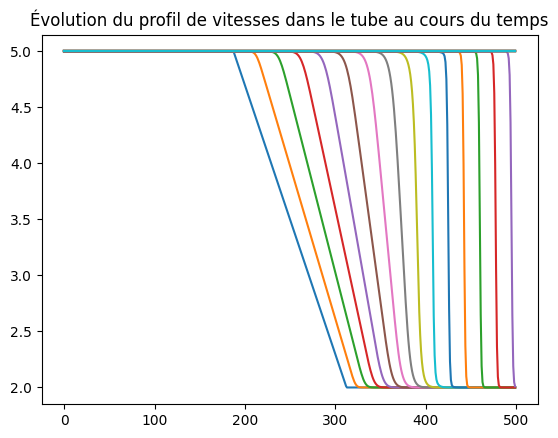

In [69]:
absc = list(range(0,N))         # Abscisse du graphe

for t in range(0, It//50) :         # Affichage de tous les profils
    plt.plot(absc,Utot[t*50])

# plt.plot(absc,Utot[50])      # Affichage d'un profil pour un temps particulier

plt.title('Évolution du profil de vitesses dans le tube au cours du temps')
plt.show()

##### <span style='color:blue'> Commentaires : </span>

$\qquad$ Les commentaires énoncés ci-dessous sont valables pour les deux cas $u_{l} < u_{r}$ et $u_{l} > u_{r}$, la seule différence étant l'inversion du profil de vitesses initial.  
On observe encore une fois une propagation de la grandeur étudiée. Ici, elle ne commence que quand la pente initiale, pour $x_{D} - \frac{l}{2} \leq x \leq x_{D} + \frac{l}{2}$, s'est suffisamment redressée. La propagation se fait donc plus rapidement là où la vitesse est la plus importante (l'écart entre des courbes successives et plus important sur les paliers de plus grande vitesse).  De même que dans les autres modélisations, la vitesse finale du gaz dans le dispositif tend vers la valeur de celle imposée à gauche. On remarque par ailleurs que la valeur de la vitesse à droite n'a pas d'influence sur la divergence de la solution.   
Attention cependant, pour un $\lambda = \frac{\Delta t}{\Delta x}$ fixé, il existe une valeur maximale de $u_{l}$ au-delà de laquelle le système devient divergent. En voici quelques exemples :

In [70]:
df = pd.DataFrame({'lambda': ['0.111', '0.333', '0.5', '0.9', '0.998'],'Valeur maximale approximative de ul': ['9', '3', '2', '1.1', '1']})
df

,lambda,Valeur maximale approximative de ul
0,0.111,9
1,0.333,3
2,0.5,2
3,0.9,1.1
4,0.998,1


Ces observations confirment dans une certaine mesure l'analogie sur la condition de stabilité énoncée plus haut :

In [71]:
df = pd.DataFrame({'1/lambda': ['9.009', '3.003', '2', '1.111', '1.002']})
df

,1/lambda
0,9.009
1,3.003
2,2
3,1.111
4,1.002


$ $

#### <span style='color:red'> 3.2 Résolution avec un profil initial de vitesses différent : cas du double choc </span>

On cherche maintenant à visualiser la propagation pour un profil initial de vitesses définit par les conditions initiales suivantes :
$$ u(0,x) = 
\left\{\begin{matrix}
\frac{u_{l}}{x_{D}-a} \: x \quad si \quad x \leq x_{D} - a
\\ u_{l} \quad si \quad x_{D} - a \leq x \leq x_{D}
\\ u_{r} \quad si \quad x \geq x_{D}
\end{matrix}\right.
$$

##### <span style='color:blue'> Programmation de la résolution : </span>

##### Définition des paramètres :

In [72]:
# Taille de la matrice :
N = 500
# Nombre d'itérations
It = 2000
# Delta x et Delta t
dltx = 1/N
dltt = 0.1*dltx
# Position du diaphragme (entier entre 0 et N):
Posd= int(N/10)

# Vitesse initiale à droite du diaphragme :
ur = 1      # /!\ ur doit être inférieur à ul 
# Vitesse initiale à gauche du diaphragme :
ul = 5     # /!\ ur doit être inférieur à ul
# Position du diaphragme :
xD = Posd * dltx

# Paramètre définissant la longueur de la portion à la vitesse ul, a < xD
a = 1/2 * xD

# Condition de stabilité :
lbd = dltt / dltx
print(('lambda ='), lbd)

lambda = 0.1


##### Vecteur vitesse initial et affichage :

In [73]:
U0 = np.zeros((N,1))
for i in range(0, N):
    if i*dltx <= xD - a:
        U0[i] = (ul-ur)/(xD-a) * i * dltx + ur
    elif i*dltx >= (xD - a) and i*dltx <= xD:
        U0[i] = ul
    else :
        U0[i] = ur
# print(U0)

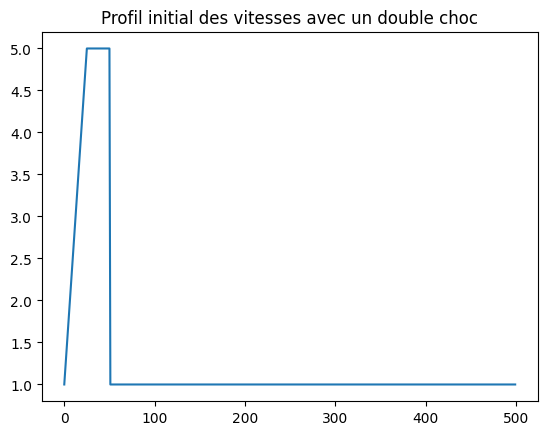

In [74]:
absc = list(range(0,N))
plt.plot(absc,U0)
plt.title('Profil initial des vitesses avec un double choc')
plt.show()

##### Création d'une liste contenant les vecteurs vitesses pour tous les temps :

In [75]:
U = np.copy(U0)
Utot = list(range(It))
Utot[0] = U0
for i in range(1, len(Utot)):
    Utot[i] = np.zeros((N,1))

##### Résolution de l'équation :

In [76]:
for t in range(1, It):
    Utot[t][0] = ur
    for i in range(1,N):
        Utot[t][i] = (1-lbd/2*Utot[t-1][i])*Utot[t-1][i]+lbd/2*(Utot[t-1][i-1])**2

##### Affichage des résultats :

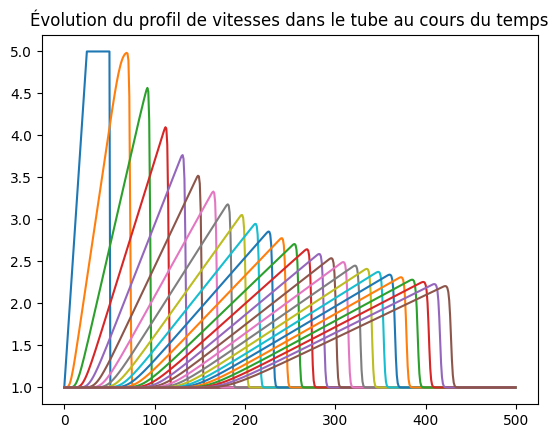

In [77]:
absc = list(range(0,N))             # Abscisse du graphe
    
for t in range (0,It//75):              # Affichage de tous les profils
    plt.plot(Utot[t*75])

# plt.plot(absc, Utot[It-1])        # Affichage d'un profil pour un temps particulier

plt.title('Évolution du profil de vitesses dans le tube au cours du temps')
plt.show()

##### <span style='color:blue'> Commentaires : </span>  
$\qquad$ Comme pour les autres modélisations, la vitesse dans le tube tend vers celle imposée à gauche. Ici, la forme du profil change. En effet, le palier présent sur le profil initial se réduit jusqu'à arrondissement : les deux chocs se rejoignent. De plus, par ce choix de conditions initiales, l'intensité du profil s'amenuise tout au long de la propagation. Encore une fois, si u > $\frac{1}{\lambda}$, la réponse diverge.  
Ces constats restent valables pour d'autres doubles chocs, comme par exemple pour un profil initial en pic.

$ $

#### <span style='color:red'> 3.3 Équation de Burgers avec viscosité : </span>

On se propose ici de reprendre l'équation de Burgers de la partie 3.1 en y rajoutant un terme de viscosité. L'équation s'écrit alors :
##### $$\frac{\partial u}{\partial t} + u \; \frac{\partial u}{\partial x} = \nu \; \frac{\partial ^{2}u}{\partial x^{2}}$$  
C'est une équation aux dérivées partielles quasi-linéaire, homogène et d'ordre 2.
On utilisera les mêmes conditions initiales que pour le problème de Burgers sans viscosité.

##### <span style='color:blue'> Discrétisation de l'équation : </span>
On choisit les mêmes discrétisations que pour la modélisation de la partie 2.  

On obtient en isolant le terme en $ u_{i}^{n+1}$ :
$$ u_{i}^{n+1} = \frac{1}{1+\frac{\lambda}{2} \: u_{i}^{n}-S} [u_{i}^{n}(1-2S) + u_{i-1}^{n}(S+\frac{\lambda}{2} \: u_{i}^{n})] \qquad \textrm{avec} \qquad \lambda = \frac{\Delta t}{\Delta x} \quad et \quad S = \frac{\nu  \Delta t}{\Delta x^{2}} $$

##### <span style='color:blue'> Stabilité du système :  </span> 
On s'inspire du problème de convection-diffusion pour déterminer des conditions de stabilité sur S et sur $\lambda$, à savoir :  
$$ $$
$\qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad$ $\; S \geq \frac{CFL^{2}}{2} \quad et \quad CFL^{2} \leq 1 \quad $ où $ \quad CFL = u \lambda$.  
On obtient alors :
$$ \mathbf{u \leq \frac{1}{\lambda}} \quad et \quad \mathbf{S \geq \frac{(u \lambda)^{2}}{2}} $$

##### <span style='color:blue'> Programmation de la résolution :  </span>

##### Définition des paramètres :

In [78]:
# Taille de la matrice :
N = 500
# Nombre d'itérations :
It = 1500
# Delta x et Delta t :
dltx = 1/N
dltt = 0.1*dltx
# Position du diaphragme (entier entre les positions 0 et N) :
Posd= int(N/2)
# Paramètre de viscosité :
visc = 0.005
# Paramètre du vecteur vitesse initial :       
l = int(N/4) * dltx


# Vitesse initiale à droite du diaphragme :
ur = 1
# Vitesse initiale à gauche du diaphragme :
ul = 2
# Position du diaphragme :
xD = Posd * dltx


# Conditions de stabilité :
lbd = dltt / dltx
S = visc * dltt / (dltx ** 2)
print(('lambda = '), lbd, ('  (u*lambda)²/2 = '), ((max(ul, ur)*lbd)**2)/2, '  S = ', S)

lambda =  0.1   (u*lambda)²/2 =  0.020000000000000004   S =  0.25000000000000006


##### Vecteur vitesse initial :

In [79]:
U0 = np.zeros((N,1))
for i in range(0, N):
    if i*dltx <= xD - l/2:
        U0[i] = ul
    elif i*dltx >= (xD - l/2) and i*dltx <= (xD + l/2):
        U0[i] = -(ul - ur)/l * i * dltx + (ul + (ul-ur)/l * (xD - l/2))
    else :
        U0[i] = ur
# print(U0)

##### Liste des vecteurs vitesses pour tous les temps :

In [80]:
U = np.copy(U0)
Utot = list(range(It))
Utot[0] = U0
for i in range(1, len(Utot)):
    Utot[i] = np.zeros((N,1))

##### Résolution :

In [81]:
for t in range(1, It):
    Utot[t][0] = ul
    for i in range(1,N):
        Utot[t][i] = 1 / (1+lbd/2*Utot[t-1][i]-S) * (Utot[t-1][i]*(1-2*S) + Utot[t-1][i-1]*(S+lbd/2*Utot[t-1][i]))

##### Affichage des résultats :

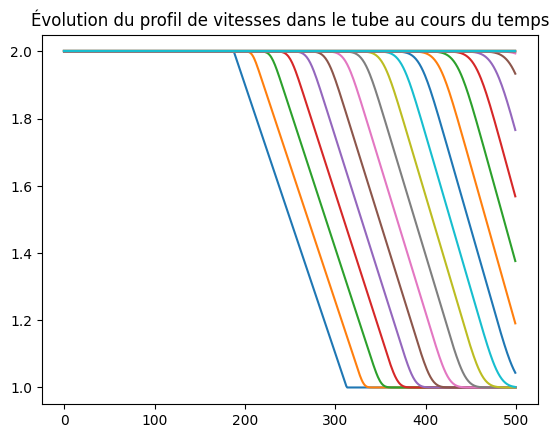

In [82]:
absc = list(range(0,N))             # Abscisse du graphe

for t in range(0, It//50) :             # Affichage de tous les profils
    plt.plot(absc,Utot[t*50])

# plt.plot(absc,Utot[It-1])         # Affichage d'un profil pour un temps particulier

plt.title('Évolution du profil de vitesses dans le tube au cours du temps')
plt.show()

##### <span style='color:blue'> Commentaires : </span>

$\qquad$ Les observations sont grandement similaires à celles de l'équation de Burgers, que l'on retrouve ici en choisissant une valeur nulle de la viscosité $visc$. Là aussi, la propagation se fait plus rapidement sur les paliers où la vitesse est la plus grande.
Les résultats obtenus restent cohérent : il existe toujours une valeur limite du paramètre $visc$ au delà de laquelle la réponse diverge, à savoir $visc$ = 0.01, c'est-à-dire S=0,5.